# spam-detector

%2020-04-19
___

In [12]:
import pandas as pd
import numpy as np
import urllib
import requests
import os
import matplotlib.pyplot as plt

DATABASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/'
LOCAL_DATABASE_PATH = 'spambase'

# Try opening local copies first before fetching from online database
try:
    spam_df = pd.read_csv(os.path.join('spambase-data', 'spambase.data'),
                      header=None, index_col=False)
    print('Reading .data file from local copy of database...')
except OSError:
    spam_df = pd.read_csv(urllib.parse.urljoin(database_url, 'spambase.data'),
                     header=None, index_col=False)
    print('Reading .data file from online of database...')

try:
    with open(os.path.join('spambase-data', 'spambase.names')) as f:
        names_file_text = f.read()
        print('Reading .names file from local copy of database...')
except OSError:
    names_file_text = requests.get(urllib.parse.urljoin(database_url, 'spambase.names')).text
    print('Reading .names file from online database...')

Reading .data file from local copy of database...
Reading .names file from local copy of database...


Attributes are specified in the .names format: http://www.cs.washington.edu/dm/vfml/appendixes/c45.htm

In [2]:
#print(names_file_text)

In [3]:
def get_attribute_names(names_file_text):
    # Anything between a '|' and the end of the line is ignored
    strip_comments = lambda line : line.split('|',1)[0]
    attr_names = []
    read_classes = False
    for line in names_file_text.splitlines():
        if len(line.strip()) == 0 or line[0] == '|':
            continue
        elif not read_classes:
            classes = strip_comments(line).split(',')
            read_classes = True
        else:
            attr_name, attr_type = strip_comments(line).split(':')
            attr_names.append(attr_name)
    return attr_names

# Add classlabel name to last column
spam_df.columns = get_attribute_names(names_file_text) + ['spam']

In [4]:
# Number of Instances: 4601 (1813 Spam = 39.4%)
# Check for null entries: none found
spam_df.isnull().sum().sum()

0

In [5]:
spam_df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [6]:
def normalise_capital_run_length_data(df):
    crl = df.filter(regex=('capital_run_length*'))
    # Min-Max normalisation
    normalise = lambda col : (col-col.min())/(col.max()-col.min())
    crl = (crl-crl.min())/(crl.max()-crl.min())
    for col_name in crl.columns:
        df[col_name] = normalise(df[col_name])
    return df
    

features = spam_df.drop('spam', axis=1)
#features2 = normalise_capital_run_length_data(features)

In [7]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 9

x_train, x_test, y_train, y_test = train_test_split(features, spam_df['spam'], test_size=0.3, random_state=RANDOM_SEED)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)

columns = x_train.columns
train_index = x_train.index
test_index = x_test.index

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_train = pd.DataFrame(data=x_train, index=train_index, columns=columns)
x_test = pd.DataFrame(data=x_test, index=test_index, columns=columns)

x_train

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
2553,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.026456,0.000000,0.000000,0.000000,0.000000,0.004114,0.005206,0.009939
2627,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001321,0.000400,0.004572
3559,0.000000,0.000000,0.415686,0.0,0.106,0.000000,0.000000,0.000000,0.000000,0.095410,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,0.000501,0.002385
3731,0.000000,0.000000,0.000000,0.0,0.064,0.000000,0.000000,0.000000,0.243346,0.000000,...,0.0,0.0,0.000000,0.000000,0.006066,0.000000,0.000000,0.002027,0.001201,0.009244
4183,0.000000,0.000000,0.049020,0.0,0.025,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.009639,0.000000,0.001447,0.000000,0.000000,0.001327,0.005006,0.014511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.009175,0.112642,0.000000,0.003503,0.001101,0.002882
1787,0.055066,0.011905,0.066667,0.0,0.000,0.013605,0.000000,0.000000,0.015209,0.007201,...,0.0,0.0,0.001538,0.000000,0.002894,0.002830,0.000000,0.002299,0.008811,0.031607
501,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.184818,0.000000,0.000000,...,0.0,0.0,0.020919,0.000000,0.012562,0.076981,0.000000,0.004655,0.002403,0.008051
4444,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.018253,0.014457,0.000000,0.000000,0.002975,0.009078,0.006908,0.030017


In [70]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(mutual_info_classif, k=20)
selector.fit(x_train, y_train)
x_train = selector.transform(x_train)
x_test = selector.transform(x_test)

In [13]:
import sklearn.metrics as skm
from sklearn.metrics import roc_curve

def display_metrics(model, x_test, y_test):
    score = model.score(x_test, y_test)
    probabilities = model.predict_proba(x_test)
    y_pred = model.predict(x_test)

    roc_auc = skm.roc_auc_score(y_test, probabilities[:, 1])
    
    fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    tp, fp, fn, tn = skm.confusion_matrix(y_test, y_pred).ravel()
    precision = skm.precision_score(y_test, y_pred)
    recall = skm.recall_score(y_test, y_pred)
    
    metrics_report = (
        f'Accuracy       : {score}\n'
        f'ROC AUC        : {roc_auc}\n'
        f'TP, FP, FN, TN : {[tp, fp, fn, tn]}\n'
        f'Precision      : {precision}\n'
        f'Recall         : {recall}\n'
    )
    print(metrics_report)

Accuracy       : 0.9572773352643013
ROC AUC        : 0.9832576201641265
TP, FP, FN, TN : [831, 22, 37, 491]
Precision      : 0.9571150097465887
Recall         : 0.9299242424242424



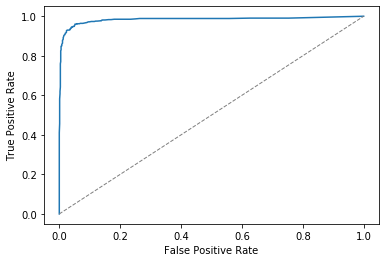

In [14]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(random_state=RANDOM_SEED)
model1 = model1.fit(x_train, y_train)

display_metrics(model1, x_test, y_test)

Accuracy       : 0.8942795076031861
ROC AUC        : 0.9474437369000676
TP, FP, FN, TN : [816, 37, 109, 419]
Precision      : 0.918859649122807
Recall         : 0.7935606060606061



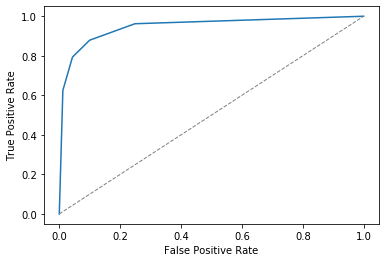

In [15]:
from sklearn.neighbors import KNeighborsClassifier

model3 = KNeighborsClassifier(n_neighbors=4)
model3.fit(x_train, y_train)

display_metrics(model3, x_test, y_test)

Accuracy       : 0.9073135409123824
ROC AUC        : 0.9616183079327864
TP, FP, FN, TN : [814, 39, 89, 439]
Precision      : 0.9184100418410042
Recall         : 0.8314393939393939



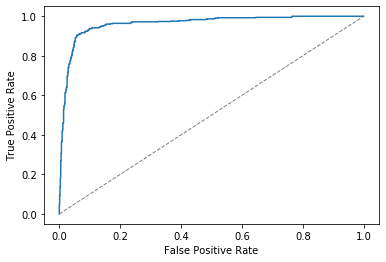

In [16]:
from sklearn.svm import SVC

svc = SVC(kernel='linear',probability=True)
svc.fit(x_train, y_train)

display_metrics(svc, x_test, y_test)

In [11]:
df.to_csv('a.csv')

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

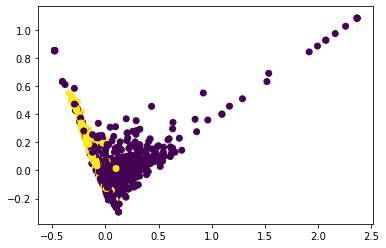

In [100]:
import matplotlib.pyplot as plt

plt.scatter(x_train[:,0],x_train[:,1], c=y_train)
#y_train.shape